In [23]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install tifffile
!pip3 install -U scikit-learn scipy matplotlib
!pip3 install imagecodecs

In [54]:
# Install TensorFlow Decision Forests.
!pip3 install tensorflow_decision_forests --upgrade
import tensorflow_decision_forests as tfdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 38.7 MB/s eta 0:00:0000:0100:01


In [24]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split

import os

import scipy

In [25]:
tiles = pd.read_csv('../210_Capstone_Aditya_Arisa_Noriel/Data/Tiles_no_binning_downsampled.csv')

In [26]:
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP
0,266,-122.512166,37.779636,-122.511026,37.778732,37.779184,-122.511596,1.0,0.0,0.0,0.0,5.0,5.0,M
1,271,-122.512166,37.775118,-122.511026,37.774214,37.774666,-122.511596,4.0,0.0,0.0,0.0,1.0,3.0,M
2,275,-122.512166,37.771503,-122.511026,37.770600,37.771052,-122.511596,0.0,0.0,0.0,0.0,1.0,0.0,M
3,390,-122.511026,37.771503,-122.509885,37.770600,37.771052,-122.510456,0.0,0.0,0.0,1.0,1.0,1.0,M
4,391,-122.511026,37.770600,-122.509885,37.769696,37.770148,-122.510456,0.0,0.0,0.0,0.0,2.0,4.0,M


Split into training and test

In [27]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID','Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'RTTYP']], 
                                   tiles['Collisions_Future'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

In [78]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

def create_linear_model():

    input = tf.keras.layers.Input(shape=(6,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error' #,
        #metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32'),
    y_train,
    epochs=20,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
65/65 [==============================] - 1s 3ms/step - loss: 95.1830 - val_loss: 89.7720
Epoch 2/20
65/65 [==============================] - 0s 2ms/step - loss: 84.4777 - val_loss: 79.0637
Epoch 3/20
65/65 [==============================] - 0s 2ms/step - loss: 73.7724 - val_loss: 68.3590
Epoch 4/20
65/65 [==============================] - 0s 2ms/step - loss: 63.0673 - val_loss: 57.6533
Epoch 5/20
65/65 [==============================] - 0s 2

In [29]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

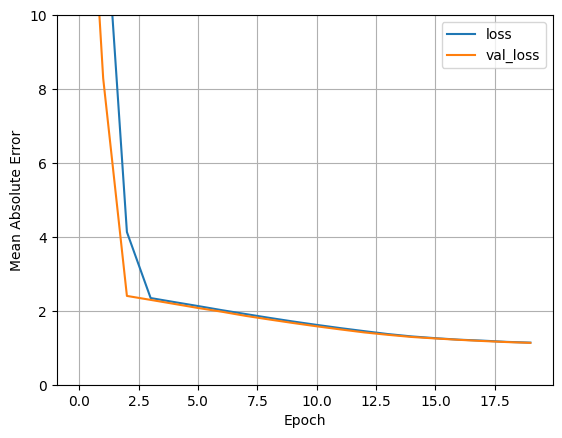

In [30]:
plot_loss(history)

**Model #2: Neural Network Using Satellite Images, Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Image Pre-Processing

In [31]:
IMAGE_PATH = '../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/' 

In [32]:
#eda
img = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [33]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [34]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [35]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [36]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [37]:
np.shape(images_mini)

(2592, 148, 188, 4)

Road Type Pre-Processing (To One Hot)

In [38]:
from sklearn.preprocessing import LabelBinarizer

In [39]:
road_type = LabelBinarizer().fit_transform(x_train['RTTYP'])

In [40]:
road_type[0]

array([0, 1, 0, 0])

In [41]:
np.shape(road_type)

(2592, 4)

Street Data Pre-Processing

In [42]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32')
street_mini = []
for row in range(len(street)):
    concat = np.concatenate((street[row], road_type[row]))
    street_mini.append([[concat]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(2592, 1, 1, 10)

Modeling <br> 

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

In [43]:
# RESNET 18 TAKEN FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py
# HELPS RUN MODEL BELOW

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

In [44]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_1[0][0]']               
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10


ValueError: in user code:

    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_3" is incompatible with the layer: expected shape=(None, 1, 1, 11), found shape=(None, 1, 1, 10)


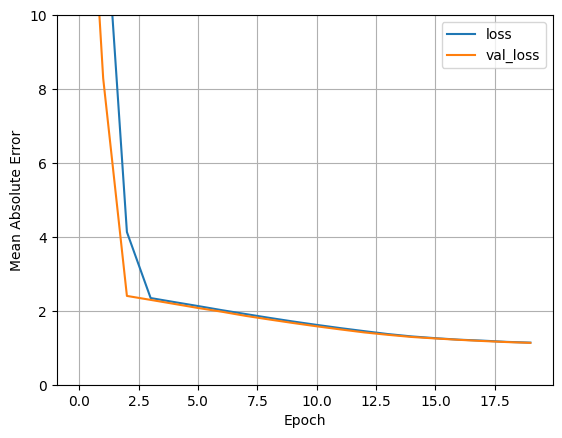

In [45]:
plot_loss(history)

**Model 2.2: Second CNN**

In [46]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet34(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_2[0][0]']               
                                                                                            

ValueError: in user code:

    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ubuntu/capstone/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_5" is incompatible with the layer: expected shape=(None, 1, 1, 11), found shape=(None, 1, 1, 10)


**Model 2.3 CNN with Concatenation instead of Addition between inputs**

In [47]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32')
# street_mini = []
# for row in range(len(street)):
#     concat = np.concatenate((street[row], road_type[row]))
#     street_mini.append([[concat]])
# street_mini = np.stack(street_mini)
# np.shape(street_mini)

In [48]:
#np.shape(street_mini[0])

In [49]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(71): 
        for j in range(91):
            concat = np.concatenate((street[k], road_type[k]))
            street_mini_2.append(concat)

In [50]:
street_mini_2 = np.reshape(street_mini_2, (len(street),71,91,11))

ValueError: cannot reshape array of size 167469120 into shape (2592,71,91,11)

In [51]:
np.shape(street_mini_2)

(16746912, 10)

In [52]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(71,91,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    combined = tf.keras.layers.Concatenate(axis = 3)([images.output, input2])
    #combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=1, activation=None, name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error' #,
    #metrics = [tf.keras.metrics.Accuracy()]
    )

history = cnn_model.fit(
    [images_mini, street_mini_2],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_3[0][0]']               
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(

KeyboardInterrupt



In [ ]:
plot_loss(history)

**Model #3: Random Forest using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
https://www.youtube.com/watch?v=5qgk9QJ4rdQ&t=181s

In [106]:
# Train a Random Forest model.

rf_model = tfdf.keras.RandomForestModel(task=2)

rf_model.fit(np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32'),
    y_train,
    validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpoe23t8gu as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.251453. Found 2592 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(649, shape=(), dtype=int32)
Validation dataset read in 0:00:00.203302. Found 649 examples.
Training model...


[INFO 2023-03-12T06:00:50.449899139+00:00 kernel.cc:1214] Loading model from path /tmp/tmpoe23t8gu/model/ with prefix bfcb79bc956742b3


Model trained in 0:00:01.307474
Compiling model...


[INFO 2023-03-12T06:00:51.015284634+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 207116 node(s), and 6 input feature(s).
[INFO 2023-03-12T06:00:51.015337642+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-03-12T06:00:51.015360531+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [107]:
print(rf_model.summary())

Model: "random_forest_model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	data:0.0
	data:0.1
	data:0.2
	data:0.3
	data:0.4
	data:0.5

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.0"  0.511802 ################
    2. "data:0.2"  0.252425 #####
    3. "data:0.5"  0.232521 #####
    4. "data:0.1"  0.182960 ###
    5. "data:0.3"  0.167750 ##
    6. "data:0.4"  0.105180 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 152.000000 ################
    2. "data:0.5" 82.000000 #######
    3. "data:0.2" 47.000000 ###
    4. "data:0.1" 19.000000 

Variable Importance: NUM_NODES:
    1. "data:0.1" 40044.000000 ################
    2. "data:0.2" 37778.000000 ###############
    3. "

In [124]:
##uncomment to show training log
#rf_model_train.make_inspector().training_logs()
rf_model_train.make_inspector().evaluation()

Evaluation(num_examples=2592, accuracy=None, loss=None, rmse=1.5945956968521853, ndcg=None, aucs=None, auuc=None, qini=None)

In [108]:
#evaluate the model
rf_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

21/21 [==============================] - 0s 2ms/step - loss: 0.0000e+00


0.0

In [109]:
#make predictions from test set
pd.DataFrame(rf_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))

21/21 [==============================] - 0s 2ms/step


,0
0,1.047173
1,0.446854
2,1.133572
3,1.636010
4,2.740341
...,...
644,2.109967
645,0.065258
646,4.529010
647,7.292774


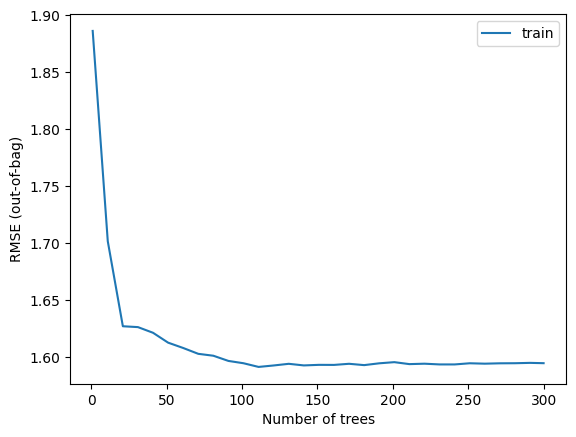

In [111]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs1], [log.evaluation.rmse for log in logs1], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.legend()
plt.show()

**Model #4: Gradient Boosted Tree using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

In [113]:
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=2)

gbt_model.fit(np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32'),
    y_train,
    validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpy0e1nqke as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.240026. Found 2592 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(649, shape=(), dtype=int32)
Validation dataset read in 0:00:00.205902. Found 649 examples.
Training model...


2023-03-12 06:07:18.192240: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-12 06:07:18.192285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-12 06:07:18.192295: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-12 06:07:18.192699: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to SQUARED_ERROR
2023-03-12 06:07:18.192740: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 2592 example(s) and 6 feature(s).
2023-03-12 06:07:18.192778: I e

Model trained in 0:00:00.384829
Compiling model...
Model compiled.


2023-03-12 06:07:18.548636: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 102
2023-03-12 06:07:18.551805: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 73 tree(s) i.e. 73  iteration(s).
2023-03-12 06:07:18.551981: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:73 valid-loss:1.383043 valid-rmse:1.383043
[INFO 2023-03-12T06:07:18.563964832+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy0e1nqke/model/ with prefix 69791c64dc9a4ba8
[INFO 2023-03-12T06:07:18.572189501+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-03-12T06:07:18.572217804+00:00 kernel.cc:1046] Use fast generic engine


In [114]:
print(gbt_model.summary())

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	data:0.0
	data:0.1
	data:0.2
	data:0.3
	data:0.4
	data:0.5

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.0"  0.416845 ################
    2. "data:0.1"  0.259975 ####
    3. "data:0.2"  0.257315 ####
    4. "data:0.5"  0.245500 ###
    5. "data:0.3"  0.196255 
    6. "data:0.4"  0.189065 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 43.000000 ################
    2. "data:0.5" 12.000000 ##
    3. "data:0.2" 11.000000 #
    4. "data:0.1"  7.000000 

Variable Importance: NUM_NODES:
    1. "data:0.2" 446.000000 ################
    2. "data:0.1" 445.000000 ###############
    3. 

In [131]:
##uncomment to show training log
#gbt_model.make_inspector().training_logs()
gbt_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=None, loss=1.3830429315567017, rmse=1.3830429315567017, ndcg=None, aucs=None, auuc=None, qini=None)

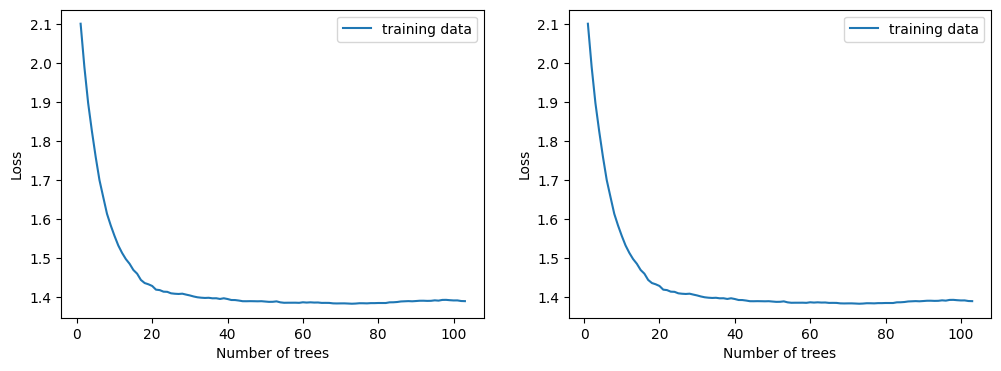

In [136]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [119]:
#evaluate the model
gbt_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

21/21 [==============================] - 0s 1ms/step - loss: 0.0000e+00


0.0

In [120]:
#make predictions from test set
pd.DataFrame(gbt_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))

21/21 [==============================] - 0s 1ms/step


,0
0,0.882962
1,0.438161
2,0.599505
3,2.119881
4,2.305691
...,...
644,2.795027
645,0.159101
646,4.683132
647,5.831048
